<a href="https://colab.research.google.com/github/1989-juliana-h/hello-world/blob/master/Intro_MMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marketing-Mix Modelling Introduction

Ideen für das Vorgehen:
1. Datenladen & EDA aus dem anderen Skript
2. Visualisierung der Daten über die Zeit und im Verhältnis zueinander
3. Ideenentwicklung welche weiteren Inputs / Features / Variablen
4. Modell suchen oder auch vergleichen
5. Modelle bauen und bewerten
6. Normalerweise würde man danach unterschiedlichste Optimierungen vornehmen
7. Interpretation

In [1]:
# Grundlegende Pakete, die wir zu Beginn benötigen.
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px


In [2]:
# Verbindung zum Google Drive herstellen
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sales_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/view_de_sample.csv")

In [4]:
sales_df.head()

,date,avg_price,sales,black_friday,corona_cases,email_sendouts,influencer_reach,google_trend,tv_brand_grp,tv_sale_grp,pla_clicks,seanb_clicks,seanb_impressions,youtube_non_sale_impressions,youtube_sale_impressions,daily_mean_air_temperature,social_brand_impressions,social_performance_impressions,social_retargeting_impressions
0,2019-01-01,76,81940,0,0,12848,14434508.0,15.99,0.0,0.0,59338,65352,0,0,0,5.88,226564,3774862,4841122
1,2019-01-02,78,107555,0,0,23802,0.0,14.82,0.0,0.0,66488,75604,0,0,0,1.86,153359,3060340,4220594
2,2019-01-03,79,119142,0,0,15205,0.0,14.04,0.0,0.0,102260,95612,0,0,0,-0.64,143915,3040598,2921786
3,2019-01-04,79,117725,0,0,24296,0.0,12.87,0.0,0.0,108136,100946,0,0,0,1.62,153285,2704194,3022022
4,2019-01-05,78,151778,0,0,25573,0.0,16.77,0.0,0.0,132834,102088,0,0,0,4.80,169264,3303968,4387184


Am Anfang einer Analyse von Marketingkanälen ist es immer ratsam die Zusammenhänge mit der abh. Variablen zu checken. Dafür eignen sich, neben Korrelationsanalysen, auch xy-Plots

In [5]:


import plotly.graph_objects as go

# Select potential marketing channels for the dropdown
marketing_cols = ['avg_price', 'black_friday', 'corona_cases', 'email_sendouts',
                  'influencer_reach', 'google_trend', 'tv_brand_grp', 'tv_sale_grp',
                  'pla_clicks', 'seanb_clicks', 'seanb_impressions',
                  'youtube_non_sale_impressions', 'youtube_sale_impressions',
                  'daily_mean_air_temperature', 'social_brand_impressions',
                  'social_performance_impressions', 'social_retargeting_impressions']

# Create figure
fig = go.Figure()

# Add a trace for each marketing channel
for col in marketing_cols:
    fig.add_trace(go.Scattergl(
        x=sales_df[col],
        y=sales_df['sales'],
        mode='markers',
        name=col,
        visible=False # Hide all traces initially
    ))

# Make the first trace visible
fig.data[0].visible = True

# Create and add dropdown menu
updatemenus = [
    dict(
        buttons=list([
            dict(
                label=col,
                method='update',
                args=[{'visible': [col == c for c in marketing_cols]},
                      {'title': f'Sales vs. {col}'}])
            for col in marketing_cols
        ]),
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.1,
        yanchor="top"
    ),
]

fig.update_layout(
    updatemenus=updatemenus,
    title='Sales vs. Marketing Channels',
    xaxis_title='Marketing Channel Value',
    yaxis_title='Sales'
)

fig.show()

### Feature Engineering

Nun gibt es die Möglichkeit bestehende Variablen zu verändern, wie zum Beispiel mit logs zu transformieren oder auch weitere Variablen zu erzeugen. Bei Zeitreihen kann man immer gut mit Lags arbeiten, das heißt den Wert der Vorperiode mit einfließen zu lassen, um die Verkäufe bspw. vorherzusagen.

In [6]:
# Convert 'date' column to datetime if it's not already
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Sort by date to ensure correct lagging and rolling calculations
sales_df = sales_df.sort_values(by='date')

# Create lagged features for sales and marketing channels
lag_days = [1, 7, 30] # Example lags: 1 day, 7 days (week), 30 days (month) --> abhängig davon welche Einheit Sie nutzen, das hängt von Datenverfügbarkeit und Präferenz ab
lag_cols = ['sales'] + marketing_cols # Columns to lag

for col in lag_cols:
    for lag in lag_days:
        sales_df[f'{col}_lag_{lag}'] = sales_df[col].shift(lag)

# Create time-based features
sales_df['day_of_week'] = sales_df['date'].dt.dayofweek # Monday=0, Sunday=6
sales_df['month'] = sales_df['date'].dt.month
sales_df['year'] = sales_df['date'].dt.year

# Add additional features: rolling averages, interaction terms, and polynomial terms

# Rolling Averages (example for sales and email_sendouts)
rolling_window = 7 # 7-day rolling window
sales_df['sales_rolling_avg_7'] = sales_df['sales'].rolling(window=rolling_window).mean()
sales_df['email_sendouts_rolling_avg_7'] = sales_df['email_sendouts'].rolling(window=rolling_window).mean()


# Interaction Term (example: email_sendouts * black_friday)
sales_df['email_blackfriday_interaction'] = sales_df['email_sendouts'] * sales_df['black_friday']

# Polynomial Term (example: email_sendouts squared)
sales_df['email_sendouts_squared'] = sales_df['email_sendouts']**2

# Display the updated dataframe with new features
display(sales_df.head())

,date,avg_price,sales,black_friday,corona_cases,email_sendouts,influencer_reach,google_trend,tv_brand_grp,tv_sale_grp,...,social_retargeting_impressions_lag_1,social_retargeting_impressions_lag_7,social_retargeting_impressions_lag_30,day_of_week,month,year,sales_rolling_avg_7,email_sendouts_rolling_avg_7,email_blackfriday_interaction,email_sendouts_squared
0,2019-01-01,76,81940,0,0,12848,14434508.0,15.99,0.0,0.0,...,NaN,NaN,NaN,1,1,2019,NaN,NaN,0,165071104
1,2019-01-02,78,107555,0,0,23802,0.0,14.82,0.0,0.0,...,4841122.0,NaN,NaN,2,1,2019,NaN,NaN,0,566535204
2,2019-01-03,79,119142,0,0,15205,0.0,14.04,0.0,0.0,...,4220594.0,NaN,NaN,3,1,2019,NaN,NaN,0,231192025
3,2019-01-04,79,117725,0,0,24296,0.0,12.87,0.0,0.0,...,2921786.0,NaN,NaN,4,1,2019,NaN,NaN,0,590295616
4,2019-01-05,78,151778,0,0,25573,0.0,16.77,0.0,0.0,...,3022022.0,NaN,NaN,5,1,2019,NaN,NaN,0,653978329


In [7]:
# Basisstatistiken Spalten
columns_to_describe = ['sales', 'avg_price'] + marketing_cols

# Deskriptive Statistiken
display(sales_df[columns_to_describe].describe())

,sales,avg_price,avg_price,black_friday,corona_cases,email_sendouts,influencer_reach,google_trend,tv_brand_grp,tv_sale_grp,pla_clicks,seanb_clicks,seanb_impressions,youtube_non_sale_impressions,youtube_sale_impressions,daily_mean_air_temperature,social_brand_impressions,social_performance_impressions,social_retargeting_impressions
count,7.320000e+02,732.000000,732.000000,732.000000,732.000000,7.320000e+02,7.320000e+02,732.000000,732.000000,732.000000,732.000000,732.000000,7.320000e+02,7.320000e+02,7.320000e+02,732.000000,7.320000e+02,7.320000e+02,7.320000e+02
mean,2.484606e+05,73.703552,73.703552,0.008197,2407.792350,4.426076e+04,3.024261e+05,24.075000,4.260017,8.566120,149640.254098,94330.672131,7.079072e+05,4.291894e+05,8.221329e+05,10.871508,5.926758e+05,2.444356e+06,5.467105e+06
std,1.083046e+05,8.444125,8.444125,0.090226,6241.476516,9.792121e+04,1.171327e+06,10.029833,12.141110,23.485009,45180.328549,39373.652110,7.930841e+05,8.529029e+05,1.823240e+06,6.598465,6.984336e+05,1.470615e+06,2.052986e+06
min,4.663500e+04,56.000000,56.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,4.510000,0.000000,0.000000,41590.000000,3952.000000,0.000000e+00,0.000000e+00,0.000000e+00,-5.000000,7.311700e+04,3.699600e+05,1.403310e+06
25%,1.789820e+05,67.000000,67.000000,0.000000,0.000000,2.081500e+03,0.000000e+00,17.100000,0.000000,0.000000,124137.000000,68323.500000,0.000000e+00,0.000000e+00,0.000000e+00,5.450628,1.915222e+05,1.327286e+06,3.980328e+06
50%,2.282750e+05,74.000000,74.000000,0.000000,0.000000,3.177200e+04,3.869000e+04,22.080000,0.000000,0.000000,145644.000000,89967.000000,1.381620e+05,0.000000e+00,0.000000e+00,10.421980,2.987805e+05,2.201991e+06,5.191743e+06
75%,2.930662e+05,80.000000,80.000000,0.000000,1171.000000,6.245175e+04,2.488202e+05,28.335000,0.000000,0.000000,171051.000000,115869.500000,1.315890e+06,3.794400e+05,1.391554e+06,16.055000,7.841520e+05,3.228676e+06,6.557249e+06
max,1.274385e+06,103.000000,103.000000,1.000000,36153.000000,2.401914e+06,1.443451e+07,79.000000,84.015800,179.492800,464718.000000,517940.000000,5.554350e+06,4.861834e+06,2.387978e+07,27.940000,7.136741e+06,1.051132e+07,1.441569e+07


In [ ]:
## Correlations (immer eine Korrelationsanalyse umsetzen, ist im multivariaten Fall immer ratsam)
## der folgende Output zeigt VIF (Variance Inflation Factor) um zu checken, welche Variablen Probleme bzgl. Multikollinearität verursachen könnten.
## Werte nahe 10 und darüber sind sehr problematisch, unter 2 ist unbedenklich.

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Select the independent variables (features) that we used in the previous model attempt
# Define the independent variables explicitly
independent_variables = ['avg_price', 'black_friday', 'email_sendouts',
                         'google_trend', 'tv_brand_grp', 'tv_sale_grp',
                         'pla_clicks', 'seanb_clicks', 'seanb_impressions',
                         'youtube_non_sale_impressions', 'youtube_sale_impressions',
                         'social_brand_impressions', 'social_performance_impressions',
                         'social_retargeting_impressions',
                         'day_of_week', 'month', 'year',
                         'sales_rolling_avg_7', 'email_sendouts_rolling_avg_7',
                         'email_blackfriday_interaction', 'email_sendouts_squared'] # Include engineered features

# Drop rows with NaN values that resulted from lagging or rolling averages
# Ensure sales_df is available from previous cells
if 'sales_df' in locals():
    model_df = sales_df.dropna(subset=independent_variables)
else:
    print("Error: sales_df DataFrame not found. Please ensure the data loading and feature engineering cells were executed.")
    model_df = pd.DataFrame() # Create an empty DataFrame to prevent further errors


if not model_df.empty:
    X = model_df[independent_variables]

    # Add a constant to the independent variables (for the intercept)
    X = sm.add_constant(X)

    # Calculate VIF for each independent variable
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    # Ensure all columns in X are numeric before calculating VIF
    X = X.select_dtypes(include=['number'])
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(X.shape[1])]

    # Display the VIF data
    print("Variance Inflation Factor (VIF) for Independent Variables:")
    display(vif_data.sort_values(by='VIF', ascending=False))
else:
    print("VIF calculation skipped due to missing data.")

Variance Inflation Factor (VIF) for Independent Variables:


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide



,feature,VIF
17,year,12.148106
3,email_sendouts,9.283712
2,black_friday,9.190087
21,email_sendouts_squared,8.190802
20,email_blackfriday_interaction,7.613992
7,pla_clicks,3.379115
8,seanb_clicks,3.019822
9,seanb_impressions,2.971917
14,social_retargeting_impressions,2.879450
13,social_performance_impressions,2.629821


,sales,avg_price,black_friday,corona_cases,email_sendouts,influencer_reach,google_trend,tv_brand_grp,tv_sale_grp,pla_clicks,...,social_brand_impressions,social_performance_impressions,social_retargeting_impressions,day_of_week,month,year,sales_rolling_avg_7,email_sendouts_rolling_avg_7,email_blackfriday_interaction,email_sendouts_squared
sales,1.000000,-0.395085,0.437860,0.079495,0.063839,-0.057289,0.555443,0.143320,0.311762,0.671469,...,0.192911,0.430257,0.517058,0.273221,0.070024,0.245473,0.581571,0.152064,0.300499,-0.033152
avg_price,-0.395085,1.000000,-0.054264,0.178429,-0.019205,0.039057,-0.285067,-0.310319,-0.089924,0.006508,...,-0.108561,-0.426342,-0.333570,-0.080080,0.469392,-0.266296,-0.259576,-0.058396,-0.047397,0.001231
black_friday,0.437860,-0.054264,1.000000,0.110202,0.057253,0.042515,0.129989,-0.031920,0.239082,0.333628,...,0.052921,-0.010232,0.064343,0.053246,0.118143,0.029645,0.202740,0.063705,0.915320,0.000780
corona_cases,0.079495,0.178429,0.110202,1.000000,0.184064,-0.047818,-0.162189,-0.082347,0.087454,0.211802,...,-0.064067,-0.042849,-0.198851,-0.042734,0.414637,0.388638,0.147137,0.396584,0.123876,0.018557
email_sendouts,0.063839,-0.019205,0.057253,0.184064,1.000000,-0.030686,0.007701,0.009110,0.054470,0.054069,...,-0.033395,0.040167,0.007013,-0.038787,0.014644,0.248500,0.081580,0.468894,0.069693,0.908923
influencer_reach,-0.057289,0.039057,0.042515,-0.047818,-0.030686,1.000000,-0.015537,-0.008102,-0.010915,-0.053361,...,0.027250,-0.036095,-0.004170,-0.068507,-0.005130,-0.103145,-0.036700,-0.039575,0.028056,-0.008657
google_trend,0.555443,-0.285067,0.129989,-0.162189,0.007701,-0.015537,1.000000,0.208855,0.141719,0.354451,...,0.251252,0.428649,0.486912,0.235754,-0.241011,0.154901,0.382910,0.071809,0.063296,-0.032466
tv_brand_grp,0.143320,-0.310319,-0.031920,-0.082347,0.009110,-0.008102,0.208855,1.000000,-0.116262,-0.052368,...,0.139873,0.089774,0.107447,0.051825,-0.041055,0.179627,0.195631,-0.000280,-0.029217,-0.011506
tv_sale_grp,0.311762,-0.089924,0.239082,0.087454,0.054470,-0.010915,0.141719,-0.116262,1.000000,0.254451,...,0.294664,0.076482,0.066512,0.078316,0.135544,-0.016905,0.209677,0.099922,0.147578,-0.009334
pla_clicks,0.671469,0.006508,0.333628,0.211802,0.054069,-0.053361,0.354451,-0.052368,0.254451,1.000000,...,0.069049,0.349682,0.423402,0.323765,0.174887,0.256399,0.432749,0.123485,0.268512,-0.059443


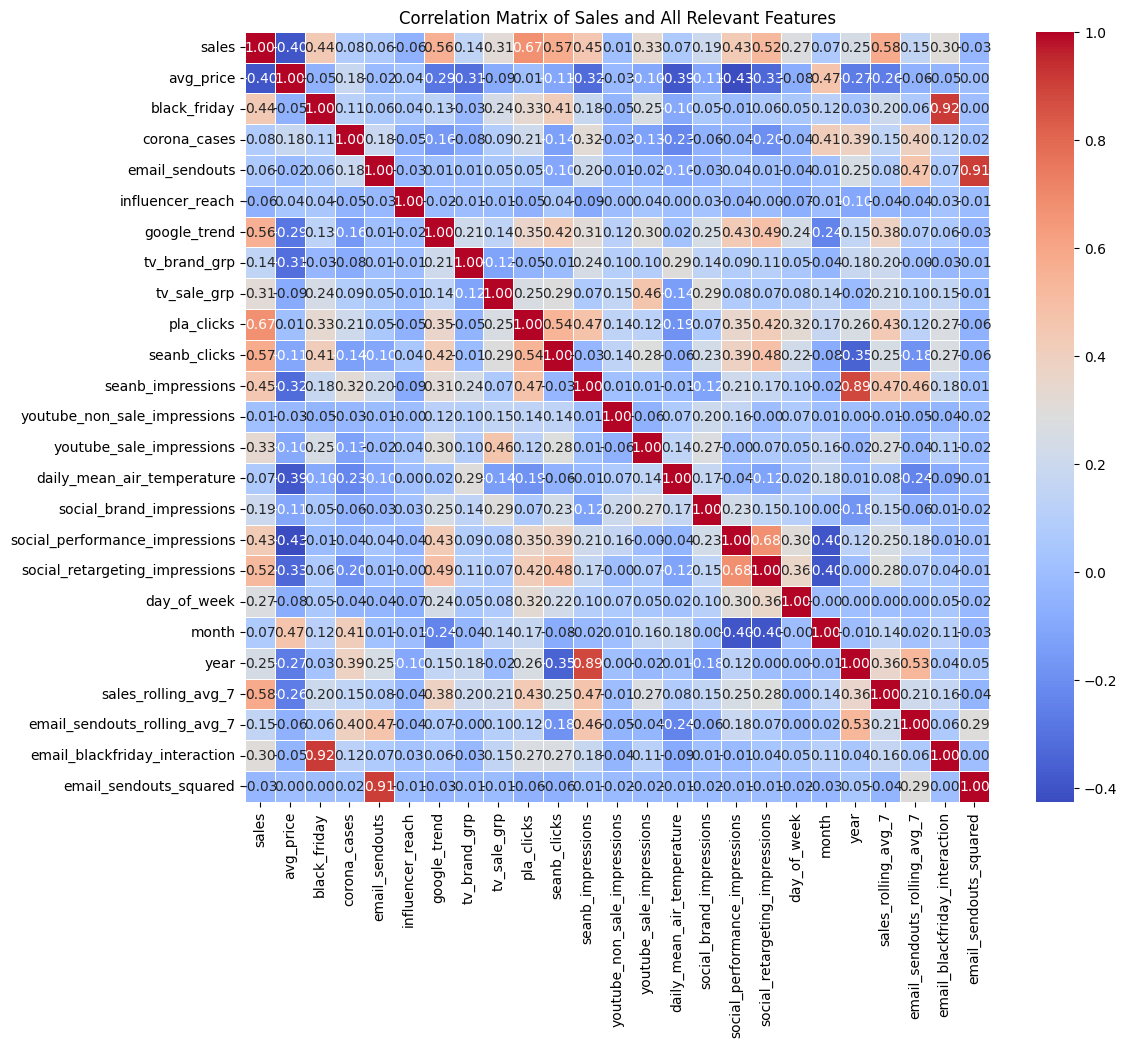

In [9]:
# Select all relevant columns for correlation analysis
all_relevant_cols = ['sales', 'avg_price', 'black_friday', 'corona_cases', 'email_sendouts',
                     'influencer_reach', 'google_trend', 'tv_brand_grp', 'tv_sale_grp',
                     'pla_clicks', 'seanb_clicks', 'seanb_impressions',
                     'youtube_non_sale_impressions', 'youtube_sale_impressions',
                     'daily_mean_air_temperature', 'social_brand_impressions',
                     'social_performance_impressions', 'social_retargeting_impressions',
                     'day_of_week', 'month', 'year',
                     'sales_rolling_avg_7', 'email_sendouts_rolling_avg_7',
                     'email_blackfriday_interaction', 'email_sendouts_squared'] # Include engineered features

# Calculate the correlation matrix
correlation_matrix_all = sales_df[all_relevant_cols].corr()

# Display the correlation matrix
display(correlation_matrix_all)

# Visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Sales and All Relevant Features')
plt.show()

Man sollte Variablen für ein Modell nicht nur auf Basis einer Korrelationsmatrix auswählen, sondern es kann rein marketintechnische Gründe haben. In einem Marketing-Mix Modell geht es nicht in erster Linie um die Vorhersageperformance, sondern darum alle Kanäle, die mich interessieren zu bewerten!Daher müssen Sie bei zu hohen Korrelationen Marketingkanäle eher zusammenfassen oder andere Aggregationen finden, die weniger Probleme bereiten. Hilfreich kann hier zum Beispiel das Zusammenfassen nach Kampagnen sein.

In [10]:
## Diese Ausgabe zeigt nochmal explizit die Korrelationen mit den Sales, um zu verstehen wie die Zusammenhänge linear grob aussehen
# Get the correlation of all relevant columns with 'sales'
sales_correlation = correlation_matrix_all['sales'].sort_values(ascending=False)

# Display the correlations
print("Correlation with Sales:")
display(sales_correlation)

# You can set a threshold to highlight particularly high correlations, e.g., absolute correlation > 0.5
high_correlation_threshold = 0.5
high_correlation_features = sales_correlation[abs(sales_correlation) > high_correlation_threshold]

print(f"\nFeatures with absolute correlation with Sales > {high_correlation_threshold}:")
display(high_correlation_features)

Correlation with Sales:


,sales
sales,1.000000
pla_clicks,0.671469
sales_rolling_avg_7,0.581571
seanb_clicks,0.574594
google_trend,0.555443
social_retargeting_impressions,0.517058
seanb_impressions,0.451222
black_friday,0.437860
social_performance_impressions,0.430257
youtube_sale_impressions,0.331753



Features with absolute correlation with Sales > 0.5:


,sales
sales,1.000000
pla_clicks,0.671469
sales_rolling_avg_7,0.581571
seanb_clicks,0.574594
google_trend,0.555443
social_retargeting_impressions,0.517058


## Regressionsanalysen

In [11]:
## Ich nehme jetzt Variablen, die mich stark interessieren und bei denen ich nicht zu hohe Bedenken habe mit hohen Korrelationen untereinander
## Durchführen einer einfachen linearen Regression, d.h. ich nehme die Verkäufe als abhängige Variable und die anderen Variablen als unabhängige Variablen


# Define the independent variables (features) and the dependent variable (target) based on user selection
independent_variables = ['pla_clicks', 'seanb_clicks', 'google_trend', 'social_retargeting_impressions',
                         'black_friday', 'social_performance_impressions', 'youtube_sale_impressions',
                         'tv_sale_grp', 'day_of_week', 'year', 'social_brand_impressions',
                         'tv_brand_grp', 'corona_cases', 'month', 'daily_mean_air_temperature',
                         'email_sendouts', 'avg_price', 'youtube_non_sale_impressions']

dependent_variable = 'sales'

# Drop rows with NaN values that might exist after feature engineering
model_df = sales_df.dropna(subset=[dependent_variable] + independent_variables)

# Define the independent and dependent variables for the model
X = model_df[independent_variables]
y = model_df[dependent_variable]

# Add a constant to the independent variables (for the intercept)
X = sm.add_constant(X)

# Create and fit the OLS model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     153.6
Date:                Wed, 10 Sep 2025   Prob (F-statistic):          4.70e-231
Time:                        14:13:21   Log-Likelihood:                -8943.9
No. Observations:                 732   AIC:                         1.793e+04
Df Residuals:                     713   BIC:                         1.801e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Hier fällt einiges auf. Was würden Sie zu dem Output sagen, hilft Ihnen dieser zu bewerten wie gut Ihr Marketing funktioniert hat?

Überlicherweise würde man jetzt an erster Stelle Transformationen vornehmen, um eine Verbesserung zu erzeugen. Jedoch zeigen die Ergebnisse, dass die Modellwahl linear zu testen nicht hilfreich sein könnte. Was sind typische Transformationen, zum Beispiel die abh. Variable zu logarithmieren da diese sehr schief ist, Sie könnten darüber nachdenken AdStocks zu berechnen. Der negative Einfluss von TV klingt erstmal nicht realistisch, dies könnte daran liegen, dass Markenbotschaften länger brauchen um eine Kaufreaktion zu verursachen, dies könnte man versuchen über eine Transformation nachzubilden.

Feature Importances from Random Forest Model:


,0
pla_clicks,0.368538
avg_price,0.184780
seanb_clicks,0.152578
google_trend,0.103644
social_retargeting_impressions,0.033349
social_performance_impressions,0.028478
daily_mean_air_temperature,0.020015
month,0.020013
youtube_sale_impressions,0.018733
social_brand_impressions,0.016082


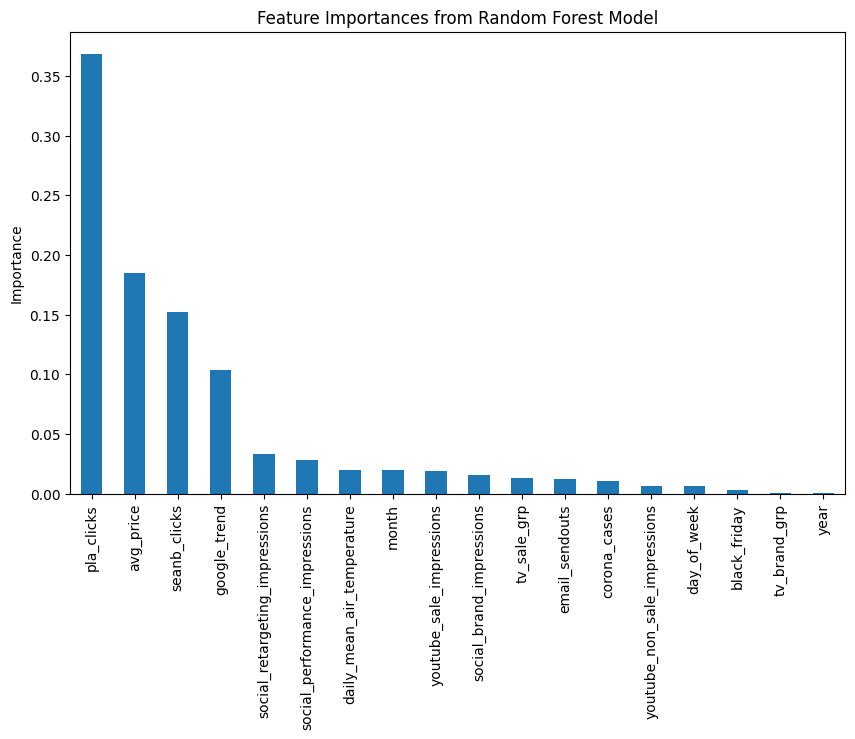

In [12]:
## wir wollen uns trotzdem noch ein nicht-lineare Modell anschauen, das hier geeignet sein könnte und zwar Random Forest.
## Link zur Python Seite: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the independent variables (features) and the dependent variable (target) based on user selection
independent_variables = ['pla_clicks', 'seanb_clicks', 'google_trend', 'social_retargeting_impressions',
                         'black_friday', 'social_performance_impressions', 'youtube_sale_impressions',
                         'tv_sale_grp', 'day_of_week', 'year', 'social_brand_impressions',
                         'tv_brand_grp', 'corona_cases', 'month', 'daily_mean_air_temperature',
                         'email_sendouts', 'avg_price', 'youtube_non_sale_impressions']

dependent_variable = 'sales'

# Drop rows with NaN values that might exist after feature engineering
model_df = sales_df.dropna(subset=[dependent_variable] + independent_variables)

# Define the independent and dependent variables for the model
X = model_df[independent_variables]
y = model_df[dependent_variable]

# Initialize and train the Random Forest Regressor model
# We'll use a random_state for reproducibility
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y) ## wichtig: das hier sind Standardparameter, hier finden Sie eine grobe Übersicht, welche Parameter optimiert werden sollten im RF.
## RF hat grundsätzlich für Klassifikationsprobleme und Regressionsprobleme unterschiedliche Basiseinstellungen, die Sie challengen sollten.
## Optimieren sollte man im Regressionsfalls beim Random Forest immer max_depth, dieser Parameter kontrolliert die Tiefe der einzelnen Bäume. Wenn ich dem Baum erlaube sehr tief zu wachsen, dann kann er grundsätzlich immer alle Variablen nutzen,
## dies führt zu tendenziell Overfitting (d.h. das Modell passt sich zu stark auf die gesehenen Datenpunkte an und wird schlecht auf neuen Daten funktionieren)

# Get feature importances (Wichtigkeit der Variablen für die Vorhersage der abh. Variablen Sales; Wichtig nur Wichtigkeit, keine Richtung des Effekts!)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# Sort feature importances and display them
sorted_feature_importances = feature_importances.sort_values(ascending=False)
print("Feature Importances from Random Forest Model:")
display(sorted_feature_importances)

# Optionally, visualize the feature importances
plt.figure(figsize=(10, 6))
sorted_feature_importances.plot(kind='bar')
plt.title('Feature Importances from Random Forest Model')
plt.ylabel('Importance')
plt.show()

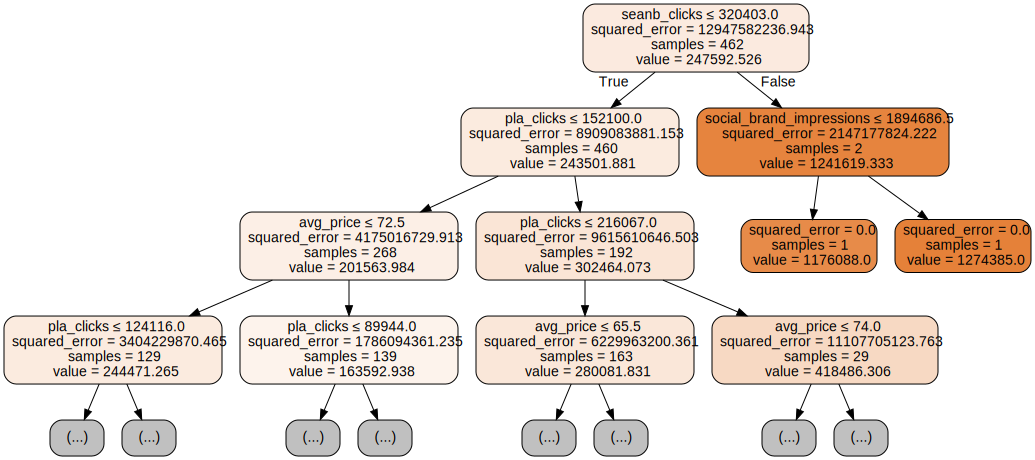

In [13]:
from sklearn.tree import export_graphviz
import graphviz
import os

# Assuming rf_model and X are available from the previous Random Forest cell
# If not, you would need to re-run that cell or load the model and data

# Select one tree from the Random Forest (e.g., the first tree)
tree_to_visualize = rf_model.estimators_[0]

# Export the tree to a DOT file
dot_data = export_graphviz(tree_to_visualize,
                           feature_names=X.columns,
                           filled=True,
                           rounded=True,
                           special_characters=True,
                           out_file=None,
                           max_depth=3) # Limit the depth for a simpler visualization

# Render the DOT data using graphviz
graph = graphviz.Source(dot_data)

# Display the tree
display(graph)

Wir lassen uns nur den Kopf ausgeben. Daher sehen wir einen einzelnen Baum des Random Forest. Jede Box wird auch als Node/Knoten bezeichnet. Der erste Knoten stellt den gesamten Datensatz dar. Die weiter unten liegenden Knoten haben sogenannte Branches, die wiederum zu anderen Knoten führen und eine Bedingung enthalten, basierend auf den beobachteten Werten von Features / unabh. Variablen. Leaf Nodes ganz unten haben keine branches, sie stellen die Vorhersage dar, bzw. den Vorhersagewert. Linien stellen die Entscheidung dar, die getroffen wird. Hier wurde zum splitten der Bäume der MSE also mean squared error genommen, dies kann eingestellt werden. Samples beinhaltet die Anzahl der Datenpunkte, die genutzt werden, dies kann auch eingestellt werden und sollte eingestellt werden, je nach datensatzgröße. Value stellt die vorhergesagten Wert für die Sales also Verkäufe dar an diesem Knoten.

Was macht ein RF grundlegend?
Erstellt viele Subdatensätze durch randomisiertes Auswählen der Datenpunkte mit "Zurücklegen", daher können verschiedene Datenpunkte auch in verschiedenen Subsets auftauchen. Features werden auch randomisiert ausgewählt. In Regressionsfällen bildet RF den Durchschnitt der Vorhersagen über alle individuellen Bäume für die finale Vorhersage. Bei Klassifikation, wie dem Churn Prediction Case, wird ein sogenannter Majority Vote durchgeführt, d.h. 3 Trees sagen 1 und 1 sagt 0 dann ist die Vorhersage 1.

im Vergleich zu einem Einzelbaum profitiert RF von den vielen Bäumen, weniger zufällige Entscheidungen.

ML Modelle in der Regressionsanwendung haben, insb. bei Interpretationsanwendungen, das Problem, dass keine Koeffizienten ausgegeben werden. RF kann ich noch visualisieren, um die Entscheidungen zu verstehen, bei NN wird dies fast unmöglich. Daher gibt es Verfahren aus zum Beispiel dem Bereich der Spieltheorie, die versuchen zu erklären, wie RF zu Entscheidungen kommt und welche Variablen er wie eingesetzt hat. Dazu werden Durchschnitte benutzt und geschaut, wenn ich Variablen variiere und deren Werte wie sich der Output, bzw. die Prediction verändert im Vergleich zum Durchschnitt. Dieses Verfahren wird als besonders fair bezeichnet und nett sich Shapley Values.

In [1]:
!pip install shap

SHAP Summary Plot (Global Feature Importance):


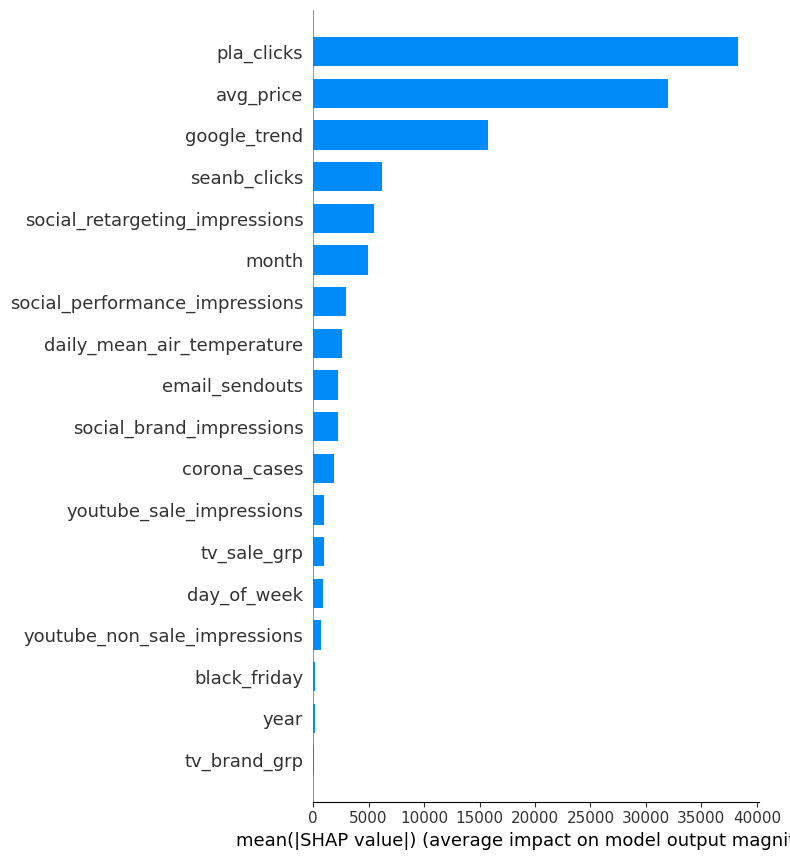

SHAP Summary Plot (Detailed Feature Impact):


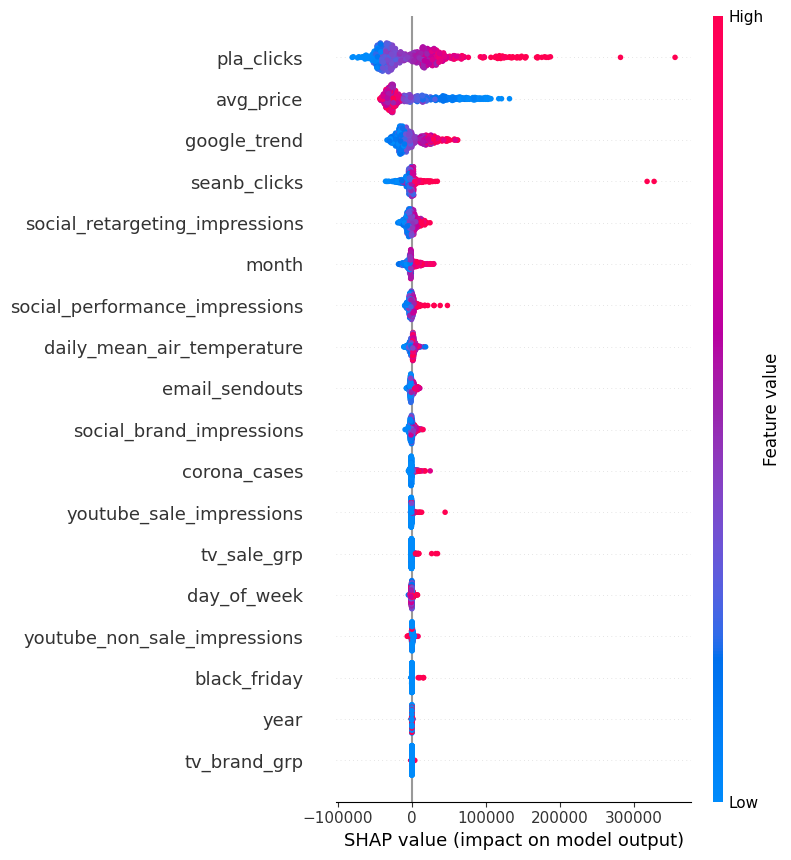


SHAP Dependence Plot for 'pla_clicks':


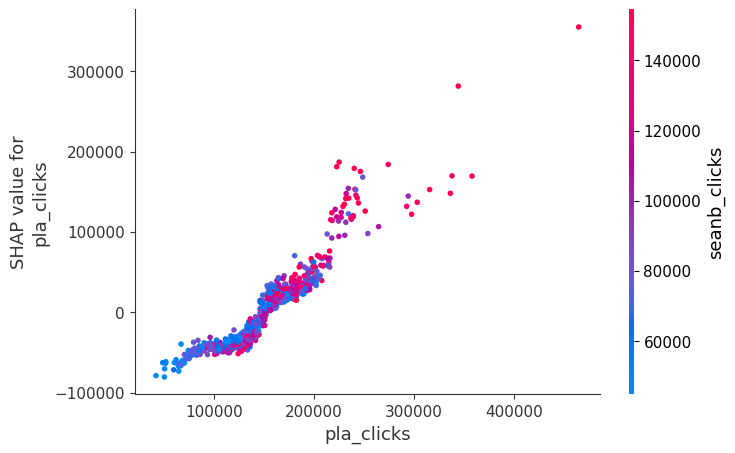

In [15]:
# Dies ist eine sehr approximative Berechnung der SHAP Werte und basiert nur auf Subsets, welche Daten benutzt werden, sollte immer bewusst gewählt werden. Shapley Values vollständig zu berechnen dauert leider zu lange, dh immer approximativ.
import shap
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Define the independent variables (features) and the dependent variable (target) based on user selection
independent_variables = ['pla_clicks', 'seanb_clicks', 'google_trend', 'social_retargeting_impressions',
                         'black_friday', 'social_performance_impressions', 'youtube_sale_impressions',
                         'tv_sale_grp', 'day_of_week', 'year', 'social_brand_impressions',
                         'tv_brand_grp', 'corona_cases', 'month', 'daily_mean_air_temperature',
                         'email_sendouts', 'avg_price', 'youtube_non_sale_impressions']

dependent_variable = 'sales'

# Ensure sales_df is available from previous cells and drop rows with NaN values
if 'sales_df' in locals():
    model_df = sales_df.dropna(subset=[dependent_variable] + independent_variables)
else:
    print("Error: sales_df DataFrame not found. Please ensure the data loading and feature engineering cells were executed.")
    model_df = pd.DataFrame() # Create an empty DataFrame to prevent further errors

if not model_df.empty:
    # Define the independent and dependent variables for the model
    X = model_df[independent_variables]
    y = model_df[dependent_variable]

    # Initialize and train the Random Forest Regressor model (re-training it here)
    # We'll use a random_state for reproducibility
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)

    # Create a SHAP explainer object
    # For tree-based models like Random Forest, TreeExplainer is suitable
    explainer = shap.TreeExplainer(rf_model)

    # Calculate SHAP values for the data
    # This might take some time depending on the size of your dataset and model complexity
    shap_values = explainer.shap_values(X)

    # Summarize the feature importances using SHAP values
    # This gives a global view of feature importance
    print("SHAP Summary Plot (Global Feature Importance):")
    shap.summary_plot(shap_values, X, plot_type="bar")

    # You can also create a more detailed summary plot
    print("SHAP Summary Plot (Detailed Feature Impact):")
    shap.summary_plot(shap_values, X)

    # To understand the impact of a single feature across the dataset, you can use a dependence plot
    # Replace 'pla_clicks' with the feature you want to examine
    print("\nSHAP Dependence Plot for 'pla_clicks':")
    shap.dependence_plot("pla_clicks", shap_values, X)
else:
    print("SHAP calculation skipped due to missing data.")

In [17]:
import plotly.graph_objects as go
import pandas as pd

# Assuming shap_df is available from the previous SHAP calculation and DataFrame creation cell
# If not, you would need to re-run that cell or ensure shap_df is created

# Select the features for which you want to plot SHAP values against sales
# These should be the columns in your shap_df that are not 'sales'
shap_features = [col for col in shap_df.columns if col != 'sales']

# Create figure
fig = go.Figure()

# Add a trace for each feature's SHAP values vs. Sales
for feature in shap_features:
    fig.add_trace(go.Scattergl(
        x=shap_df[feature],
        y=shap_df['sales'],
        mode='markers',
        name=feature,
        visible=False # Hide all traces initially
    ))

# Make the first trace visible (optional, choose a default feature)
if shap_features: # Check if the list is not empty
    fig.data[0].visible = True

# Create and add dropdown menu
updatemenus = [
    dict(
        buttons=list([
            dict(
                label=feature,
                method='update',
                args=[{'visible': [feature == f for f in shap_features]},
                      {'title': f'Sales vs. SHAP Value for {feature}',
                       'xaxis': {'title': f'SHAP Value for {feature}'}}]) # Update x-axis title as well
            for feature in shap_features
        ]),
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.1,
        yanchor="top"
    ),
]

# Set initial layout and titles
initial_title = f'Sales vs. SHAP Value for {shap_features[0]}' if shap_features else 'Sales vs. SHAP Values'
initial_xaxis_title = f'SHAP Value for {shap_features[0]}' if shap_features else 'SHAP Value'

fig.update_layout(
    updatemenus=updatemenus,
    title=initial_title,
    xaxis_title=initial_xaxis_title,
    yaxis_title='Sales',
    height=600 # Adjust height as needed
)

fig.show()

## Dashboard / Automatisierung

Wie implementiere ich jetzt so ein Modell in der operativen Praxis? Über welche Steps muss ich mir Gedanken machen?
1. Sind die Datenquellen automatisiert in einer Datenbank verfügbar? Zum Beispiel müsste ich ein automatisiertes Skript haben für Google Trend Daten. Häufig sind Daten von Marketingkanälen nur über spezifische Tools zugänglich --> hoher Engineering Aufwand, der nicht unterschätzt werden darf.
2. ModellOptimierung und ModellMaintenance. Das Modell kann fehler auslösen, es können sich Kanäle und andere Sacheverhalte, wie zum Beispiel die weltwirtschaftliche Lage verändern, sodass ich Änderungen vornehmen muss. Dies löst man optimalerweise über Train/Test Set-Up. Sie haben in der Cloud oder auf einem Server ein automatisiertes Skript, das läuft und gleichzeitig haben sie einen Testbereich, indem Sie Änderungen durchführen können, die sich nicht direkt auf das laufende Modell auswirken. Dies geht sowohl in der Google Cloud als auch in AWS als auch in Azure.
3. Automatisierte Visualisierung. Basisfunktionen aus Visualisierungstools wie Tableau, PowerBI oder Google Looker reichen nicht immer aus. Hier können Sie zum Beispiel StreamLit nutzen und Dashboards selbst entwickeln. Streamlit ist für Python ebenfalls verfügbar.

#### Prototype Dashboard Elements (In-Notebook)

Next to streamlit it is also possible to use Voilà for Prototype Dashboards; can help to check with stakeholders how the final dashboard should look like and also to find the necessary functionalities

### Simulating Cost Data and Calculating ROI

Am Ende soll so ein Modell operativen Mehrwert liefern, dafür können Sie den ROI berechnen. Bei der linearen Regression sind die Ableitungen recht simpel. Ein Beispiel mit unechten Zahlenf finden Sie unten. Beim Random Forest müssen Sie über weitere Analysen eine durchschnittliche Steigung berechnen oder wie sich Steigungen verändern und auf welchen ROI Sie dann in bestimmten Bereichen kommen. Häufig wollen Marketingmanager einen Wert haben, wenn wir allerdings Marketing realistisch abbilden wollen, ist dies oft eine zu vereinfachte Sicht auf die Welt. Wenn solche Interpretationen getroffen werden, sollte dies immer als Warning mitgegeben werden.

In [19]:
# Simulate daily cost data for example marketing channels
# In a real scenario, you would load this data from your marketing platforms

simulated_costs = {
    'pla_clicks': 0.5,      # Example cost per click
    'seanb_clicks': 0.3,    # Example cost per click
    'google_trend': 0,      # Google Trend is free, so cost is 0
    'social_retargeting_impressions': 0.005, # Example cost per impression
    'email_sendouts': 0.01  # Example cost per email sent
}

# Calculate total spend for each simulated channel over the dataset period
# Assuming the units in the dataframe are counts (clicks, impressions, sendouts)
total_spend = {}
for channel, cost_per_unit in simulated_costs.items():
    if channel in sales_df.columns:
        total_spend[channel] = (sales_df[channel] * cost_per_unit).sum()
        print(f"Simulated Total Spend for {channel}: ${total_spend[channel]:,.2f}")
    else:
        print(f"Warning: Channel '{channel}' not found in the dataframe.")


# To calculate ROI, we need the estimated incremental sales from each channel.
# This is where the model results come in. For a linear model, the coefficient can be a starting point,
# but for more complex models or accurate ROI, you'd typically use the model to predict sales
# with and without the marketing activity.

# For a simplified example using linear model coefficients (be cautious with this interpretation,
# especially if multicollinearity is high or the model is not a perfect fit):

# Assuming the linear model 'model' is available from the OLS regression cell
# And the independent_variables list used for that model is also available

estimated_incremental_sales = {}
if 'model' in locals() and 'independent_variables' in locals():
    print("\nEstimating Incremental Sales based on Linear Model Coefficients (Simplified):")
    for channel in simulated_costs.keys():
        if channel in independent_variables:
            # Get the coefficient for the channel from the linear model
            # Need to handle the constant term if it's in the model.params index
            if channel in model.params.index:
                 # For simplicity, we'll multiply the coefficient by the total volume of the channel
                 # A more accurate method would involve predicting sales with and without the channel
                 estimated_incremental_sales[channel] = model.params[channel] * sales_df[channel].sum()
                 print(f"Estimated Incremental Sales from {channel}: {estimated_incremental_sales[channel]:,.2f}")
            else:
                 print(f"Warning: Channel '{channel}' not found in linear model parameters.")

        else:
             print(f"Warning: Channel '{channel}' was not included in the linear regression model.")

    # Calculate ROI for channels where we have both spend and estimated incremental sales
    print("\nCalculating ROI:")
    for channel, spend in total_spend.items():
        if channel in estimated_incremental_sales and spend > 0: # Avoid division by zero
            # ROI = (Incremental Revenue - Cost) / Cost * 100
            # Assuming incremental sales directly translate to incremental revenue
            roi = ((estimated_incremental_sales[channel] - spend) / spend) * 100
            print(f"ROI for {channel}: {roi:.2f}%")
        elif channel in estimated_incremental_sales and spend == 0:
             print(f"ROI for {channel}: Infinite (no cost)")
        else:
            print(f"Cannot calculate ROI for {channel} (missing spend or estimated incremental sales).")

else:
    print("\nLinear model or independent_variables not found. Cannot perform simplified ROI calculation based on coefficients.")

# Note: A more robust ROI calculation often involves:
# 1. Using the model to predict sales with and without the specific marketing activity.
# 2. Calculating the difference in predicted sales (incremental sales).
# 3. Using average order value or revenue per sale to convert incremental sales units to incremental revenue.
# 4. Subtracting the marketing spend from the incremental revenue to get the net return.
# 5. Dividing the net return by the marketing spend.

Simulated Total Spend for pla_clicks: $54,768,333.00
Simulated Total Spend for seanb_clicks: $20,715,015.60
Simulated Total Spend for google_trend: $0.00
Simulated Total Spend for social_retargeting_impressions: $20,009,603.67
Simulated Total Spend for email_sendouts: $323,988.76

Estimating Incremental Sales based on Linear Model Coefficients (Simplified):
Estimated Incremental Sales from pla_clicks: 65,945,902.01
Estimated Incremental Sales from seanb_clicks: 46,379,737.87
Estimated Incremental Sales from google_trend: 39,353,060.07
Estimated Incremental Sales from social_retargeting_impressions: 36,802,927.94
Estimated Incremental Sales from email_sendouts: 564,317.60

Calculating ROI:
ROI for pla_clicks: 20.41%
ROI for seanb_clicks: 123.89%
ROI for google_trend: Infinite (no cost)
ROI for social_retargeting_impressions: 83.93%
ROI for email_sendouts: 74.18%


Dies mit RF umzusetzen ist nicht so einfach. Hier eine vereinfachte Idee über eine Baseline, sollte jedoch mit Vorsicht genoßen werden und zeigt hier auch einen negativen Return On Investment

In [21]:
# Assuming rf_model and X are available from the previous Random Forest cell
# Assuming simulated_costs is available from the previous ROI calculation cell

# Select a marketing channel to calculate ROI for (e.g., 'pla_clicks')
channel_to_analyze = 'pla_clicks'

if channel_to_analyze in X.columns and channel_to_analyze in simulated_costs:
    # 1. Make predictions with the channel at its actual levels
    y_pred_actual = rf_model.predict(X)

    # 2. Create a copy of the data and set the channel's values to a baseline (e.g., 0)
    X_no_channel = X.copy()
    # Consider what a reasonable baseline is. Setting to 0 might not be appropriate if the channel
    # always has some activity. Using the minimum observed value or the average of non-zero values
    # could be alternatives depending on your data. For simplicity here, we'll use 0.
    X_no_channel[channel_to_analyze] = 0

    # Make predictions with the channel removed/baselined
    y_pred_no_channel = rf_model.predict(X_no_channel)

    # 3. Calculate the estimated incremental sales
    estimated_incremental_sales_rf = (y_pred_actual - y_pred_no_channel).sum() # Sum over the entire period

    # 4. Get the total cost for the channel (using simulated costs)
    total_cost_channel = (sales_df[channel_to_analyze] * simulated_costs[channel_to_analyze]).sum()


    print(f"Estimated Incremental Sales from {channel_to_analyze} (Random Forest): {estimated_incremental_sales_rf:,.2f}")
    print(f"Simulated Total Cost for {channel_to_analyze}: ${total_cost_channel:,.2f}")

    # 5. Calculate ROI
    if total_cost_channel > 0:
        roi_rf = ((estimated_incremental_sales_rf - total_cost_channel) / total_cost_channel) * 100
        print(f"Estimated ROI for {channel_to_analyze} (Random Forest): {roi_rf:.2f}%")
    elif estimated_incremental_sales_rf > 0:
         print(f"Estimated ROI for {channel_to_analyze} (Random Forest): Infinite (no cost, positive impact)")
    else:
        print(f"Estimated ROI for {channel_to_analyze} (Random Forest): Undefined (no cost, no positive impact)")

else:
    print(f"Channel '{channel_to_analyze}' not found in features or simulated costs.")

# Note: This is a simplified approach. More sophisticated methods might consider
# marginal ROI (ROI for an additional unit of spend) or account for interactions
# with other channels more explicitly in the prediction scenarios.

Estimated Incremental Sales from pla_clicks (Random Forest): 41,811,520.15
Simulated Total Cost for pla_clicks: $54,768,333.00
Estimated ROI for pla_clicks (Random Forest): -23.66%


### Exploring ROI with GEMINI

Wie gut funktioniert Gemini AI jetzt, wenn ich sie challenge, dass ich operationalisierbare Ergebnisse haben möchte?

## Weitere Steps?

1. Kosten / Nutzen immer im Blick behalten. Bei MMMs können die Kosten schnell explodieren für den Entwicklungsaufwand, daher ist hier immer zu überlegen Intern versus Extern. Für die Entscheidung sollten die Ziele klar sein, wer hat KnowHow im Unternehmen und wie oft brauchen wir neue Informationen aus dem Modell.
2. Häufig werden Themen wie Datenaufbereitung und auch die Automatisierung sowie auch Instandhaltung deutlich unterschätzt, daher ist das PM im KI Bereich essenziell und darf nicht außer Acht gelassen werden.
3. Braucht man immer eine Automatisierung? Manuelle Reports zum Verschicken oder CustomGPTs können oft schon das Ziel erfüllen. Daher sollten zusätzlich zur Dimension Inhouse versus External immer auch Zwischenvarianten betrachtet werden.

Über allem steht: Werden auf Basis der KI-Produkte Entscheidungen getroffen und verbessert und wie muss das Endergebnis aussehen damit operative Entscheidungen unterstützt werden können. Sie können das Marketingbudget auch aus dem Bauch heraus treffen. Wenn Sie sich entscheiden in diesem Bereich KI einzusetzen, müssen Sie auch Szenarien abwägen, was passiert, wenn die KI mir xy sagt und dies passt nicht zu meiner Intuition?